# <font color = "blue" weigth = "bold"> <center> Stabilité temporelle du modèle de segmentation

Afin de déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, je vais procéder à l'analyse de la stabilité du modèle sur une période en procédant comme suite :

* Effectuer une segmentation des données à l'aide de l'algorithme K-means sur deux périodes différentes ;
* Calculer les métriques de stabilité (ARI et AMI) sur ces deux périodes ;
* Analyser l'évolution de ces métriques

## <font color = "blue"> Importation des librairies et chargement du jeu de données

### <font color = "blue"> Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from yellowbrick.cluster import KElbowVisualizer
from plotly import graph_objs as go
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.precision = 2

### <font color="blue"> Chargement du jeu de données

In [2]:
data = pd.read_csv("data_olist.csv")
data.head()

,customer_unique_id,order_purchase_timestamp,feedback,geolocation_lat,geolocation_lng,price,freight_value,boleto,credit_card,debit_card,voucher,comment_length,comment_count,recence,frequence,montant,score_moyen,installment_payment_mean,average_basket,max_basket,min_basket,total_order,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance,délai_livraison
0,"('0000366f3b9a7992bf8c76cfdf3221e2', '0000366f...",2018-05-10 10:56:27,1,-23.34,-46.83,129.90,12.00,0.0,1.0,0.0,0.0,111.0,1.0,111.0,1.0,141.90,5.0,8.0,141.90,141.90,141.90,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,340.84,6.41
1,"('0000b849f77a49e4a4ce2b2a4ca5be3f', '0000b849...",2018-05-07 11:11:27,1,-23.56,-46.79,18.90,8.29,0.0,1.0,0.0,0.0,0.0,1.0,114.0,1.0,27.19,4.0,1.0,27.19,27.19,27.19,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,327.88,3.29
2,"('0000f46a3911fa3c0805444483337064', '0000f46a...",2017-03-10 21:05:03,1,-27.54,-48.63,69.00,17.22,0.0,1.0,0.0,0.0,0.0,1.0,536.0,1.0,86.22,3.0,8.0,86.22,86.22,86.22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,243.86,25.73
3,"('0000f6ccb0745a6a4b88665a16c9f078', '0000f6cc...",2017-10-12 20:29:41,1,-1.31,-48.48,25.99,17.63,0.0,1.0,0.0,0.0,12.0,1.0,320.0,1.0,43.62,4.0,4.0,43.62,43.62,43.62,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2683.23,20.04
4,"('0004aac84e0df4da2b147fca70cf8255', '0004aac8...",2017-11-14 19:45:42,1,-23.51,-47.47,180.00,16.89,0.0,1.0,0.0,0.0,0.0,1.0,287.0,1.0,196.89,5.0,6.0,196.89,196.89,196.89,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,282.53,13.14


**_Calcul de la périodicité des commandes_**

In [3]:
# Conversion de la colonne "order_purchase_timestamp" au format date
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

In [4]:
# Calcul de la période de commande en faisant la différence entre les dates de la dernière commande et de la première commande

time_delta = int((data.order_purchase_timestamp.max() - data.order_purchase_timestamp.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 22 mois.


**_Détermination des dates de référence._**

In [5]:
# Définition de la date de référence 
date_reference = data['order_purchase_timestamp'].max()
date_reference

Timestamp('2018-08-29 15:00:37')

**_Génération des dates de référence pour différentes périodes_**<br> Ces variables de date de référence seront utilisées ultérieurement pour définir les limites temporelles des périodes.

In [6]:
# Données de référence de la première période - 1 mois
data_ref_1mois = date_reference - pd.DateOffset(months=1)
print(f'Données de référence - 1 mois : {data_ref_1mois}')
# Données de référence de la première période  - 2 mois
data_ref_2mois = date_reference - pd.DateOffset(months=2)

# Données de référence de la première période historique - 3 mois
data_ref_3mois = date_reference - pd.DateOffset(months=3)

# Données de référence de la première période historique - 4 mois
data_ref_4mois = date_reference - pd.DateOffset(months=4)

# Données de référence de la première période historique - 5 mois
data_ref_5mois = date_reference - pd.DateOffset(months=5)

# Données de référence de la première période historique - 6 mois
data_ref_6mois = date_reference - pd.DateOffset(months=6)

# Données de référence de la première période historique - 7 mois
data_ref_7mois = date_reference - pd.DateOffset(months=7)

# Données de référence de la première période historique - 8 mois
data_ref_8mois = date_reference - pd.DateOffset(months=8)

# Données de référence de la première période historique - 9 mois
data_ref_9mois = date_reference - pd.DateOffset(months=9)

# Données de référence de la première période historique - 10 mois
data_ref_10mois = date_reference - pd.DateOffset(months=10)

# Données de référence de la première période historique - 11 mois
data_ref_11mois = date_reference - pd.DateOffset(months=11)

Données de référence - 1 mois : 2018-07-29 15:00:37


**_Modélisation sur les périodes sélectionnées_** <br> Je vais procéder comme suite :
* Entrainer l'algorithme KMeans (en reprenant les paramètres ayant servit à la modélisation) sur une période. Puis stocker les résultats dans un groupe ;
* Entraîner l'algorithme KMean sur la période de référence, en ne conservant que les clients présents sur la période définit et ensuite stocker les résultats dans un groupe ;
* Comparer les deux groupes des clients.

In [7]:
# DDéfintion d'un tableau vide pour stocker les résultats des k-means
resultats_kmeans = pd.DataFrame({})

In [8]:
# Déficition d'une fonction pour réaliser la modélisation sur plusieurs périodes

from numpy.random import seed
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler


def model_periode(dataframe, dataframe_resutat, date_ref, titre, nb_clusters):
    
    # Cration d'une copie du dataframe
    df_copie = dataframe.copy()
    
    # Création d'une trame de données pour la période initiale
    df_hist = df_copie[df_copie['order_purchase_timestamp'] < date_ref]

    # Création d'un dataframe pour la période référence en filtrant les données pour ne garder que les clients présents dans l'ensemble de données initial "df_hist"
    df_copie_ref = dataframe.copy()
    df_ref = df_copie_ref[df_copie_ref.customer_unique_id.isin(df_hist.customer_unique_id)]

    # Sélection des variables numériques (pour exlure les variables "order_purchase_timestamp" et "customer_unique_id")
    cols_num_cat = df_ref.select_dtypes(include=[np.number]).columns.to_list()
    
    # Traitement des données initiales "df_hist"
    # Préparation des données
    X_df_hist = df_hist[cols_num_cat].values
    features_df_hist = df_hist[cols_num_cat].columns

    # Standardisation des données "df_hist"
    scaler = RobustScaler()
    X_scaled_hist = scaler.fit_transform(X_df_hist)

    # Transformation des données "df_hist" standardisées en Dataframe
    X_scaled_hist = pd.DataFrame(X_scaled_hist,
                                 index=df_hist.index,
                                 columns=features_df_hist)
    
    # Traitement des données référence "df_ref"
    # Préparation des données
    X_df_ref = df_ref[cols_num_cat].values
    features_df_ref = df_ref[cols_num_cat].columns

    # Standardisation des données "df_ref"
    scaler = RobustScaler()
    X_scaled_ref = scaler.fit_transform(X_df_ref)

    # Trasformations des données "df_ref" standardisées en Dataframe
    X_scaled_ref = pd.DataFrame(X_scaled_ref,
                                index=df_ref.index,
                                columns=features_df_ref)
    
    # Instanciation de kmeans 
    kmeans = KMeans(n_clusters=nb_clusters, n_init=10)

    # Entaînement de kmeans sur les données "X_scaled_hist", sur la période définit
    kmeans.fit(X_scaled_hist)
    kmeans_labels_hist = kmeans.labels_
    X_scaled_hist['Cluster'] = kmeans.labels_
    
    
    # Entaînement de sur sur les données "X_scaled_ref", sur la période de référence
    kmeans.fit(X_scaled_ref)
    kmeans_labels_ref = kmeans.labels_
    X_scaled_ref['Cluster'] = kmeans.labels_
    # Calcul du score ARI
    ARI_kmeans = metrics.adjusted_rand_score(kmeans_labels_ref,
                                             kmeans_labels_hist)

    # Sauvegarde de l'ARI dans le tableau de résultats
    dataframe_resutat = pd.concat([dataframe_resutat, pd.DataFrame({
    'Periode': [titre],
    'Date': [date_ref],
    'ARI': [ARI_kmeans]
})], ignore_index=True)
    

    return dataframe_resutat, X_scaled_hist, X_scaled_ref

In [9]:
# Création d'une liste contenant les dates de références 
dates = [data_ref_1mois, data_ref_2mois, data_ref_3mois, data_ref_4mois, data_ref_5mois,
         data_ref_6mois, data_ref_7mois, data_ref_8mois, data_ref_9mois, data_ref_10mois,
         data_ref_11mois]

# Création d'une liste contenant les titres correpondants aux dates de références
titres = ['Juillet18_août18', 'Juin18_août18', 'Mai18_août18', 'Avril18_août18', 'Mars18_août18',
          'Février18_août18', 'Janvier18_août18', 'Decembre17_août18', 'Novembre17_août18',
          'Octobre17_août18', 'Septembre17_août18']

# Création d'une boucle pour itérer sur ces listes en utilisant la fonction zip() pour associer chaque date à son titre correspondant
for date, titre in zip(dates, titres):
    resultats_kmeans, df_hist, df_ref = model_periode(data, resultats_kmeans, date, titre, 6)
    # Faites ce que vous voulez avec les résultats (par exemple, les afficher)

In [10]:
resultats_kmeans

,Periode,Date,ARI
0,Juillet18_août18,2018-07-29 15:00:37,0.70
1,Juin18_août18,2018-06-29 15:00:37,0.98
2,Mai18_août18,2018-05-29 15:00:37,0.96
3,Avril18_août18,2018-04-29 15:00:37,0.48
4,Mars18_août18,2018-03-29 15:00:37,0.99
5,Février18_août18,2018-02-28 15:00:37,0.96
6,Janvier18_août18,2018-01-29 15:00:37,0.94
7,Decembre17_août18,2017-12-29 15:00:37,0.99
8,Novembre17_août18,2017-11-29 15:00:37,1.00
9,Octobre17_août18,2017-10-29 15:00:37,1.00


In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=resultats_kmeans["Date"], y=resultats_kmeans["ARI"], mode='markers+lines', name='ARI', marker=dict(symbol='circle', size=8, color = '#4AA3A2')))

fig.update_layout(
    title="Mesure de la stabilité du modèle K-means",
    xaxis=dict(title="Mois"),
    showlegend=True,
    legend=dict(x=0, y=1),
    height=600,
    width=800,
)

fig.show()

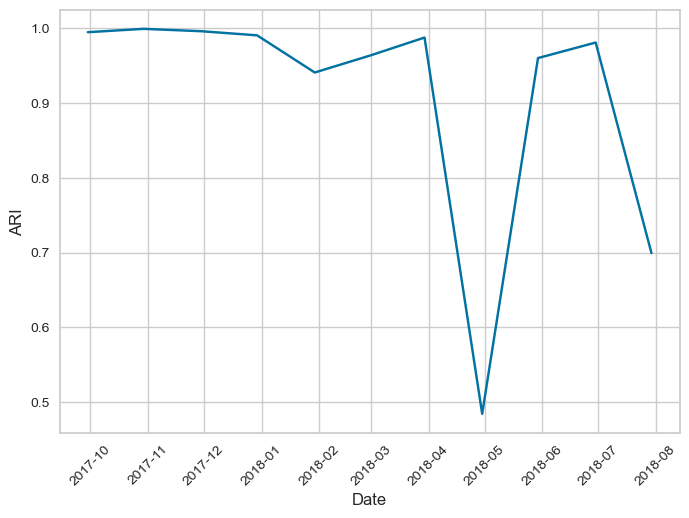

In [12]:
sns.lineplot(x="Date", y="ARI", data=resultats_kmeans)
plt.xticks(rotation=45)
plt.show()

J'ai utilisé le score ARI pour évaluer la stabilité du modèle de segmentation obtenu avec l'algorithme K-Means. Le tracé ci-dessus décrit l'évolution de ce score mois après mois.

Les 7 premiers mois, le score ARI varie très peu et reste élevé (supérieur à 0,94), mais au-delà de 7 mois, le score chute fortement pour passer en dessous de 0,5. Ceci signifie qu'il faudra prévoir une maintenance du programme de segmentation tous les 7 mois et de revérifier la stabilité. Il pourrait, par conséquence, être nécessaire de redéfinir les segments clients à chaque maintenance.